In [51]:
from simbad_download import resolve_name
import pandas as pd

from astropy.coordinates import ICRS, SkyCoord
import astropy.units as u

import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
from extinction import add_colors_and_abs_mag

from scipy.optimize import minimize
import optuna

In [52]:
%matplotlib notebook  

In [3]:
KAPPA = 4.74047

In [4]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name('NGC 188')

In [5]:
sources = pd.read_csv('./ngc 188 5d.csv')

In [6]:
len(sources)

301561

In [7]:
sources.head()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error
0,575922816240170368,42.067044,0.718274,87.526657,0.631198,0.440745,0.724745,0.608138,-1.037192,0.951654,3.024045,0.948973
1,575921205628441344,39.110251,0.033311,87.436855,0.027938,0.711382,0.031558,22.542192,2.641619,0.045092,4.007487,0.039009
2,575921308706406400,39.462327,0.567571,87.449999,0.471968,0.631252,0.562629,1.121969,3.403206,0.823528,1.344071,0.753207
3,575921476210326272,40.225136,0.087846,87.459656,0.073540,0.428389,0.094495,4.533451,0.542979,0.143017,6.791917,0.120112
4,575921510570062336,40.025703,0.118615,87.461371,0.101676,0.576776,0.118824,4.854045,0.713331,0.170573,6.121507,0.156338


In [8]:
sky_coords = SkyCoord(ra=sources['ra'].values,
                      dec=sources['dec'].values,
                      unit=(u.deg, u.deg),
                      frame=ICRS)

sources.ra = sky_coords.ra.wrap_at(180 * u.deg).value

In [9]:
coordinates = SkyCoord(ra=sources.ra.values*u.deg, dec=sources.dec.values*u.deg, 
                       distance=(1/sources.parallax.values)*u.kpc, radial_velocity=cp_radvel*u.km/u.s,
                       pm_ra_cosdec=sources.pmra.values*u.mas/u.yr, pm_dec=sources.pmdec.values*u.mas/u.yr,
                       frame=ICRS)

The perpendicular and parallel motions $\mu_\parallel$ and $\mu_\perp$ are defined as:

$\begin{bmatrix}
\mu_\parallel \\
\mu_\perp
\end{bmatrix} = 
\begin{bmatrix}
\rm sin\theta & \rm cos\theta \\
-\rm cos\theta & \rm sin\theta \\
\end{bmatrix}
\begin{bmatrix}
\mu_{\alpha*} \\
\mu_\delta
\end{bmatrix}$

where $\theta$ is defined as:

$\rm tan\theta = \frac{\rm sin(\alpha_{\rm cp}-\alpha)}{\rm cos\delta\rm tan\delta_{\rm cp}-\rm sin\delta\rm cos(\alpha_{\rm cp}-\alpha)}$

The coordinates of the convergent point $(\alpha_{\rm cp}, \delta_{\rm cp})$ can be set to the cluster center.

Since we want $\mu_\perp=0$, we can define $\mathrm{tan}\theta$ as:

$\rm{tan}\theta=\frac{\mu_{\alpha*,cp}}{\mu_{\delta,cp}}$

So we work in:

$
\begin{bmatrix}
v_\parallel \\
v_\perp
\end{bmatrix}=
\begin{bmatrix}
\frac{\mu_\parallel}{\pi}-\frac{\mu_{\delta,cp}}{\pi_c} \\
\frac{\mu_\perp}{\pi}
\end{bmatrix}
$

In [10]:
galactic_cartesian = coordinates.galactic.cartesian

In [11]:
def cp_proper_motions(ra: np.float32, 
                      dec: np.float32,
                      par: np.float32,
                      pmra: np.float32,
                      pmdec: np.float32) -> np.matrix:
    
    tan_theta = cp_pmra/cp_pmdec
    
    sin_theta = tan_theta/np.sqrt(1+np.power(tan_theta, 2))
    cos_theta = 1/np.sqrt(1+np.power(tan_theta, 2))
    mu_values = np.squeeze(np.asarray(np.matmul(
                np.matrix([[sin_theta, cos_theta],
                           [-cos_theta, sin_theta]]),
                np.matrix([pmra, pmdec]).T)))
    return mu_values/par-np.array([cp_pmra/cp_par, 0.])

In [12]:
matrices = np.vectorize(cp_proper_motions, otypes=[np.ndarray])

In [13]:
cp_proper_motions(cp_ra+.0001, cp_dec+.0001, cp_par, cp_pmra, cp_pmdec)

array([-3.76602784e-01, -2.19715619e-16])

In [14]:
proper_motions = np.stack(matrices(sources.ra.values, sources.dec.values, sources.parallax.values,
         sources.pmra.values, sources.pmdec.values))

<IPython.core.display.Javascript object>


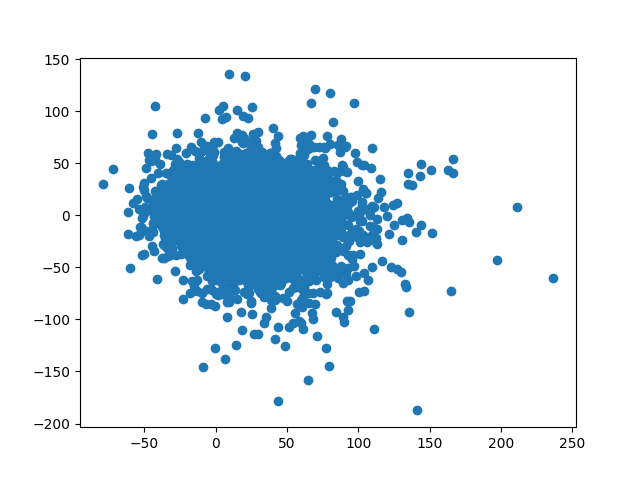

In [15]:
plt.scatter(proper_motions[:, 0], proper_motions[:, 1])

In [16]:
cluster_values = pd.DataFrame(data=np.array([
    galactic_cartesian.x.value,
    galactic_cartesian.y.value,
    galactic_cartesian.z.value,
    proper_motions[:, 0],
    proper_motions[:, 1]
]).T, columns=['x', 'y', 'z', 'u_par', 'u_per'])

In [17]:
from scipy import stats

In [18]:
cluster_values.describe()

,x,y,z,u_par,u_per
count,301561.000000,301561.000000,301561.000000,301561.000000,301561.000000
mean,-1.143834,1.772945,0.839831,4.865873,1.969290
std,0.363206,0.549702,0.270168,9.311390,7.893219
min,-2.292589,0.961483,0.399264,-79.365328,-187.379645
25%,-1.384274,1.315781,0.625048,-0.123497,-1.561240
50%,-1.065109,1.652953,0.781458,4.114580,2.060941
75%,-0.846609,2.144768,1.011263,8.697442,5.809466
max,-0.568047,3.304153,1.824493,236.722444,135.409641


In [19]:
#cluster_values_q = cluster_values[(np.abs(stats.zscore(cluster_values)) < 1).all(axis=1)]

In [20]:
#sources_q = sources[(np.abs(stats.zscore(cluster_values)) < 1).all(axis=1).values]

In [21]:
scaler = StandardScaler()

s = scaler.fit_transform(cluster_values.values)

In [22]:
len(s)

301561

In [23]:
import matplotlib.pyplot as plt

bleh

In [24]:
from sklearn.cluster import DBSCAN

In [25]:
from_lit: pd.DataFrame = pd.read_csv('./data/ngc_188/literature.csv').drop(columns='Unnamed: 0')
from_lit.head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
0,NGC 188 1054,303084,2004PASP..116.1012S,11.191250,85.256734,2020yCat.1350....0G,0.5409,0.0189,2020yCat.1350....0G,-2.178,...,3.0,2020yCat.1350....0G,-42.18,NaN,2008AJ....135.2264G,Gaia EDR3 573942325217383424|TIC 461601298|2MA...,573942325217383424,5.739423e+17,461601298.0,8
1,Cl* NGC 188 DGV 1869,303589,2004PASP..116.1012S,9.743203,85.559916,2020yCat.1350....0G,0.5191,0.0232,2020yCat.1350....0G,-2.250,...,3.0,2020yCat.1350....0G,-42.74,NaN,2008AJ....135.2264G,Gaia EDR3 573982010715088256|TIC 461597588|2MA...,573982010715088256,5.739820e+17,461597588.0,8
2,NGC 188 2014,303857,2004PASP..116.1012S,10.977598,85.205113,2020yCat.1350....0G,0.4785,0.0404,2020yCat.1350....0G,-2.368,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573935899946338816|TIC 461599220|2MA...,573935899946338816,5.739359e+17,461599220.0,6
3,NGC 188 1152,303904,2004PASP..116.1012S,11.164145,85.242850,2020yCat.1350....0G,0.6603,0.0853,2020yCat.1350....0G,-2.111,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941942962994176|TIC 461601256|2MA...,573941942962994176,5.739419e+17,461601256.0,3
4,NGC 188 3129,303875,2004PASP..116.1012S,11.151445,85.352770,2020yCat.1350....0G,0.5443,0.0169,2020yCat.1350....0G,-2.387,...,3.0,2020yCat.1350....0G,-42.69,NaN,2008AJ....135.2264G,Gaia EDR3 573944215002950144|TIC 461601456|2MA...,573944215002950144,5.739442e+17,461601456.0,8


In [81]:
def dbscan(sources: pd.DataFrame, eps: float = 0.5, min_samples=20) -> np.array:
    dbscan_clust = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_fit = dbscan_clust.fit(sources)

    dbscan_labels = dbscan_fit.labels_
    unique_labels = set(dbscan_labels)
    print(f'Classified into {len(unique_labels)} labels.')
    return dbscan_labels

def label_sources(sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    sources_labelled = pd.DataFrame(columns=[*sources.columns, 'label'],
                                    data=np.concatenate([sources,
                                                         labels.reshape((-1, 1))], axis=1))
    sources_labelled['label'] = sources_labelled.label.astype(int)
    return sources_labelled

def get_clustered_and_noise(labelled_sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    non_noise_labels: np.array = labels[labels!=-1]
    unique_label_count = np.unique(non_noise_labels, return_counts=True)
    
    if len(unique_label_count) == 0:
        return None, None
    
    largest_non_noise: int = unique_label_count[0][np.argmax(unique_label_count[1])]
    
    clustered: pd.DataFrame = labelled_sources[labelled_sources['label']==largest_non_noise]
    noise: pd.DataFrame = labelled_sources[labelled_sources['label']!=largest_non_noise]
        
    print(f'Clustered: {len(clustered)}/{len(labelled_sources)}')
        
    return clustered, noise

def is_in_cluster_function(cluster_sources: pd.DataFrame,
                           source_id_col_name: str = 'source_id'):
    def is_in_cluster(source_id: int) -> bool:
        return len(cluster_sources[cluster_sources[source_id_col_name]==source_id]) > 0
    return is_in_cluster

def check_for_cluster_children(from_lit: pd.DataFrame,
                               cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(cluster_sources)
    in_cluster = np.vectorize(is_in_cluster)(from_lit['EDR3 id'].values)
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return in_cluster

def check_for_undiscovered_sources(from_lit: pd.DataFrame,
                                   cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(from_lit, 'EDR3 id')
    in_cluster = np.vectorize(is_in_cluster)(cluster_sources['source_id'].values)
    falses = in_cluster[~in_cluster]
    print(f'{len(falses)}/{len(in_cluster)} objects were previously unreported.')
    return len(falses)/len(in_cluster)

In [37]:
is_in_edr3 = is_in_cluster_function(sources)
from_lit_edr3 = from_lit[np.vectorize(is_in_edr3)(from_lit['EDR3 id'].values)]

In [29]:
dbscan_clust = DBSCAN(eps=.25, min_samples=50)
dbscan_fit = dbscan_clust.fit(s)

dbscan_labels = dbscan_fit.labels_
unique_labels = set(dbscan_labels)
print(f'Classified into {len(unique_labels)} labels: {unique_labels}')

print(dbscan_labels.shape)

sources['labels'] = dbscan_labels

Classified into 2 labels: {0, -1}
(301561,)


In [38]:
sources['labels'].value_counts()

 0    171433
-1    130128
Name: labels, dtype: int64

In [39]:
in_cluster = check_for_cluster_children(from_lit_edr3, sources[sources['labels']==0])

1251/1327 objects found in the cluster.


In [42]:
labelled_sources = label_sources(sources, dbscan_labels)
clustered, noise = get_clustered_and_noise(labelled_sources, dbscan_labels)

Clustered: 171433/301561


In [32]:
def contamination(clustered, all_sources):
    return (len(clustered[clustered.ra<np.quantile(all_sources.ra, .1)]) +
            len(clustered[clustered.ra>np.quantile(all_sources.ra, .9)]) +
            len(clustered[clustered.dec<np.quantile(all_sources.dec, .1)]) +
            len(clustered[clustered.dec>np.quantile(all_sources.dec, .9)]))

In [43]:
contamination(clustered, sources)

60474

In [46]:
in_cluster = check_for_cluster_children(from_lit_edr3, clustered)

1251/1327 objects found in the cluster.


In [50]:
len(from_lit_edr3[in_cluster])

1251

In [59]:
np.unique(dbscan_labels)

array([-1,  0])

In [74]:
labels = dbscan(s, 0.25, 2)

Classified into 3820 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [67]:
np.unique(labels)

array([-1])

In [79]:
def objective(trial):
    eps = trial.suggest_float('eps', 0.01, 0.2)
    min_samples = trial.suggest_int('min_samples', 2, 20)
    
    dbscan_labels = dbscan(s, eps, min_samples)
    if len(np.unique(dbscan_labels)) == 1:
        return -len(sources)
    
    labelled_sources = label_sources(sources, dbscan_labels)
    clustered, noise = get_clustered_and_noise(labelled_sources, dbscan_labels)
    in_cluster = check_for_cluster_children(from_lit_edr3, clustered)
    
    return len(from_lit_edr3[in_cluster])-contamination(clustered, sources)

In [80]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-08-01 13:58:23,905] A new study created in memory with name: no-name-d0d97ffd-1a43-4846-a533-1fd446fc463d


Classified into 2330 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

[I 2022-08-01 13:59:03,202] Trial 0 finished with value: -74075.0 and parameters: {'eps': 0.17364254481570057, 'min_samples': 4}. Best is trial 0 with value: -74075.0.


1294/1327 objects found in the cluster.
Classified into 353 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 2

[I 2022-08-01 13:59:40,329] Trial 1 finished with value: -54211.0 and parameters: {'eps': 0.17204656725231815, 'min_samples': 10}. Best is trial 1 with value: -54211.0.


1262/1327 objects found in the cluster.
Classified into 3955 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

[I 2022-08-01 13:59:57,958] Trial 2 finished with value: -3643.0 and parameters: {'eps': 0.09135199932019471, 'min_samples': 4}. Best is trial 2 with value: -3643.0.


1125/1327 objects found in the cluster.
Classified into 139 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, -1}
Clustered: 106/301561


[I 2022-08-01 14:00:06,289] Trial 3 finished with value: 106.0 and parameters: {'eps': 0.01874364940380352, 'min_samples': 2}. Best is trial 3 with value: 106.0.


106/1327 objects found in the cluster.
Classified into 24520 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

[I 2022-08-01 14:00:22,702] Trial 4 finished with value: -4414.0 and parameters: {'eps': 0.0882821904261135, 'min_samples': 2}. Best is trial 3 with value: 106.0.


1126/1327 objects found in the cluster.
Classified into 115 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, -1}
Clustered: 8616/301561


[I 2022-08-01 14:00:43,210] Trial 5 finished with value: -408.0 and parameters: {'eps': 0.11128103417195305, 'min_samples': 15}. Best is trial 3 with value: 106.0.


1118/1327 objects found in the cluster.
Classified into 8115 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

[I 2022-08-01 14:01:04,420] Trial 6 finished with value: -29764.0 and parameters: {'eps': 0.11378976922969647, 'min_samples': 3}. Best is trial 3 with value: 106.0.


1217/1327 objects found in the cluster.
Classified into 168 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, -1}
Clustered: 31448/301561


[I 2022-08-01 14:01:27,995] Trial 7 finished with value: -6871.0 and parameters: {'eps': 0.12748381751891422, 'min_samples': 16}. Best is trial 3 with value: 106.0.


1135/1327 objects found in the cluster.
Classified into 8744 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 

[I 2022-08-01 14:02:13,525] Trial 8 finished with value: -85297.0 and parameters: {'eps': 0.1895470651587189, 'min_samples': 2}. Best is trial 3 with value: 106.0.


1301/1327 objects found in the cluster.
Classified into 3 labels: {0, 1, -1}
Clustered: 804/301561


[I 2022-08-01 14:02:24,522] Trial 9 finished with value: 776.0 and parameters: {'eps': 0.04946359857621168, 'min_samples': 16}. Best is trial 9 with value: 776.0.


776/1327 objects found in the cluster.


In [82]:
study.best_params

{'eps': 0.04946359857621168, 'min_samples': 16}

In [83]:
study.best_value

776.0

<IPython.core.display.Javascript object>


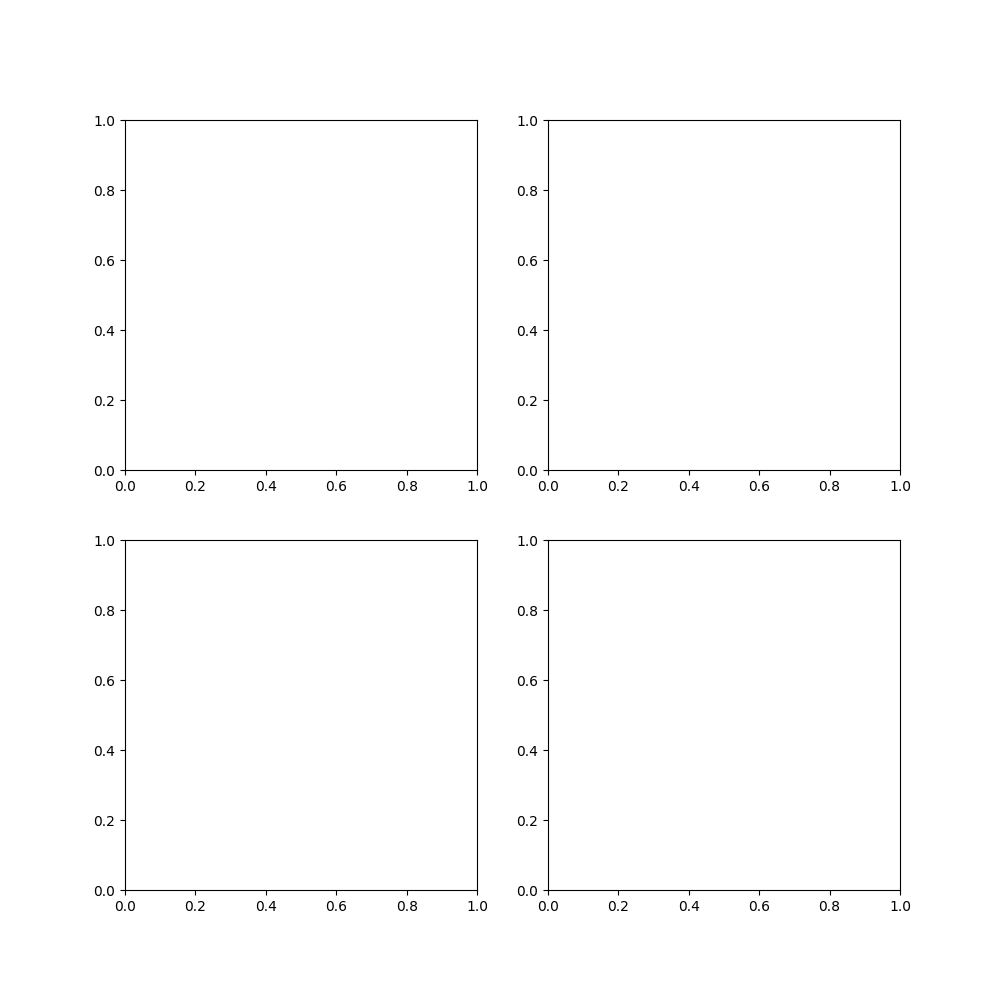

In [89]:
_, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

In [91]:
plt.sca(ax[0, 0])
optuna.visualization.plot_contour(study, params=["eps", "min_samples"])

In [86]:
optuna.visualization.plot_param_importances(study)

In [88]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
missed = from_lit_edr3[~in_cluster]
found = from_lit_edr3[in_cluster]

In [ ]:
missed.head()

In [ ]:
missed_dr3 = pd.merge(left=missed[['EDR3 id']], right=sources, left_on='EDR3 id', right_on='source_id')

In [ ]:
found_dr3 = pd.merge(left=found[['EDR3 id', 'TIC']], right=sources, left_on='EDR3 id', right_on='source_id')

In [ ]:
plt.figure(figsize=(5, 4));
plt.hist(missed_dr3.parallax_over_error, bins=25, color='tomato');
plt.axvline(10, color='black', linestyle='--');

In [ ]:
correct_par = missed_dr3[missed_dr3['parallax_over_error']>10]

In [ ]:
len(correct_par)

In [ ]:
plt.figure(figsize=(5, 4));
plt.hist(correct_par.parallax, bins=25, alpha=.5, color='tomato');
plt.hist(found_dr3.parallax, bins=25, alpha=.5, color='royalblue');

In [ ]:
plt.figure(figsize=(5, 4));
plt.errorbar(found_dr3.pmra, found_dr3.pmdec,
             xerr=found_dr3.pmra_error, yerr=found_dr3.pmdec_error,
             color='royalblue', alpha=.5, fmt='o');
plt.errorbar(correct_par.pmra, correct_par.pmdec,
             xerr=correct_par.pmra_error, yerr=correct_par.pmdec_error,
             color='tomato', alpha=.5, fmt='o');

In [ ]:
pmra_std = np.std(found_dr3.pmra)
pmdec_std = np.std(found_dr3.pmdec)
pm_correct = missed_dr3[(np.abs(missed_dr3.pmra-cp_pmra)<pmra_std) & (np.abs(missed_dr3.pmdec-cp_pmdec)<pmdec_std)]

In [ ]:
len(pm_correct)

In [ ]:
plt.figure(figsize=(5, 4));
plt.hist(pm_correct.parallax, bins=25, alpha=.5, color='tomato');
plt.hist(found_dr3.parallax, bins=25, alpha=.5, color='royalblue');

In [ ]:
found_dr3.to_csv('./found_cp_tails.csv', index=None)